In [1]:

from scipy.stats import pearsonr
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

from Config import get_data_dir


In [2]:
main_dir = './Models'

# Collect the data for each training mode
data = {}
for mode_dir in glob.glob('{}/*'.format(main_dir)):
    mode = mode_dir.split('/')[-1]
    
    if mode != 'initial-transfer' and mode.split('-')[0] != 'partial': #Ignore the models we aren't analyzing
        # Aggregate the data for that mode across the trials
        data_mode = {}
        count = 0
        for trial_dir in glob.glob('{}/trial*'.format(mode_dir)):
            with open('{}/results.json'.format(trial_dir), 'r') as f:
                data_tmp = json.load(f)
            for key in data_tmp:
                if key in data_mode:
                    data_mode[key].append(data_tmp[key])
                else:
                    data_mode[key] = [data_tmp[key]]

        # We want the average
        for key in data_mode:
            data_tmp = data_mode[key]
            data_mode[key] = '{} ({})'.format(np.round(np.mean(data_tmp), 4), np.round(np.std(data_tmp), 4))

        # Compute aggregated accuracy metrics
        data[mode] = data_mode

# Convert the nested dictionary into a csv
modes = [key for key in data]
modes.sort()
metrics = [key for key in data[modes[0]]]

# Group the results by pair
with open('./FindSCs.json', 'r') as f:
    pairs = json.load(f)

metric_groups = {}
metric_groups['avg'] = [('MAP', 'MAP'), ('MAR', 'MAR')]

for pair in pairs:
    n = len(pair)
    main = pair.split('-')[0]
    spurious = pair.split('-')[1]
    n_main = len(main)
    tmp = []
    for metric in metrics:
        if metric[:n] == pair:
            name = metric[n+1:]
            tmp.append((name, metric))
    metric_groups[pair] = tmp

# Save the results
for group in metric_groups:

    df = pd.DataFrame()
    df['Mode'] = modes
    for info in metric_groups[group]:
        name = info[0]
        metric = info[1]
        data_tmp = []
        for mode in modes:
            data_tmp.append(data[mode][metric])
        df[name] = data_tmp

    df.to_csv('./Analysis/{}.csv'.format(group), index = False)

In [3]:
# Show the results for each object pair and then the aggregated differences

def remove_var_info(df):
    def remove(x):
        return x.split(' ')[0]
    return df.applymap(remove)

groups = {}
for pair in pairs:
    spurious = pair.split('-')[1]    
    if spurious in groups:
        groups[spurious].append(pair)
    else:
        groups[spurious] = [pair]

cols_acc = ['Mode', 'both', 'just_main', 'just_spurious', 'neither', 'b-precision', 'b-recall', 'r-gap', 'h-gap']
    
def compare(corrected, baseline):
    modes = [corrected, baseline]

    diffs_acc = {}
    for metric in cols_acc[1:]:
        diffs_acc[metric] = []
    
    stats = {}
    stats['P(M)'] = []
    stats['P(S)'] = []

    for key in groups:
        group = groups[key]
        print()
        print()
        print(key)
        print()
        for pair in group:

            print(pair)
                        
            with open('{}/train/splits/{}.json'.format(get_data_dir(), pair), 'r') as f:
                splits = json.load(f)
                
            for split in splits:
                splits[split] = len(splits[split])
            
            P_M = (splits['both'] + splits['just_main']) / (splits['both'] + splits['just_spurious'] + splits['just_main'] + splits['neither'])
            P_S = (splits['both'] + splits['just_spurious']) / (splits['both'] + splits['just_spurious'] + splits['just_main'] + splits['neither'])
            P_S_g_M = splits['both'] / (splits['both'] + splits['just_main'])  
            stats['P(M)'].append(P_M)
            stats['P(S)'].append(P_S)
            print('P(M), P(S|M), P(S):', np.round(P_M, 3), np.round(P_S_g_M, 3), np.round(P_S, 3))
            
            df = pd.read_csv('./Analysis/{}.csv'.format(pair))

            print('Acc Comparison')
            df_tmp = remove_var_info(df.loc[df['Mode'].isin(modes), cols_acc].copy())
            print(df_tmp.to_string(index = False)) 

            for metric in diffs_acc:
                data_tmp = {}
                names = df_tmp['Mode'].values
                values = df_tmp[metric].values
                for i in range(len(names)):
                    data_tmp[names[i]] = float(values[i])
                if not np.any(data_tmp == -1):
                    diffs_acc[metric].append(data_tmp[modes[0]] - data_tmp[modes[1]])
            print()
            print()

    print()
    print()
    print()
    print()
    print('Aggregate Differences:')
    
    def get_stats(key, diffs):
        print(key)
        data = diffs[key]
        print('mean (std):', np.round(np.mean(data), 3), np.round(np.std(data), 3))
        print('median:', np.round(np.median(data), 3))
        if key in ['r-gap', 'h-gap']:
            print('prob < 0:',  np.round(np.mean(np.array(data) < 0), 3))
        else:
            print('prob > 0:',  np.round(np.mean(np.array(data) > 0), 3))
        print()
        print()

    for key in diffs_acc:
        plt.hist(diffs_acc[key], bins = 15)
        plt.title(key)
        plt.show()
        plt.close()
        get_stats(key, diffs_acc)
        
    plt.scatter(np.array(stats['P(S)']) * np.array(stats['P(M)']), diffs_acc['b-precision'])
    plt.xlabel('P(M) * P(S)')
    plt.ylabel('Change in b-precision')
    plt.show()
    plt.close()




person

cell+phone-person
P(M), P(S|M), P(S): 0.041 0.797 0.542
Acc Comparison
         Mode    both just_main just_spurious neither b-precision b-recall   r-gap   h-gap
     auto-aug  0.2221    0.2784        0.9915  0.9955      0.6982   0.2502  0.0564  0.0043
 initial-tune  0.2824    0.3239        0.9845  0.9958      0.5956   0.3031  0.0415  0.0113


handbag-person
P(M), P(S|M), P(S): 0.058 0.91 0.542
Acc Comparison
         Mode   both just_main just_spurious neither b-precision b-recall   r-gap   h-gap
     auto-aug  0.105     0.025        0.9944  0.9992      0.5678    0.065    0.08  0.0048
 initial-tune  0.242    0.0083        0.9754  0.9995      0.3946   0.1252  0.2337   0.024


donut-person
P(M), P(S|M), P(S): 0.013 0.548 0.542
Acc Comparison
         Mode    both just_main just_spurious neither b-precision b-recall   r-gap   h-gap
     auto-aug  0.2424    0.4569        0.9981  0.9977      0.6891   0.3497  0.2145  0.0005
 initial-tune  0.2727    0.4397        0.9981  0.9976    

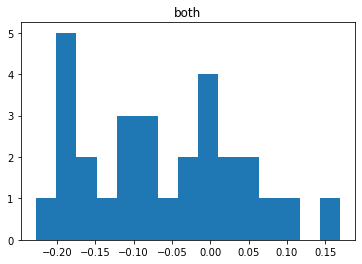

both
mean (std): -0.064 0.101
median: -0.073
prob > 0: 0.276




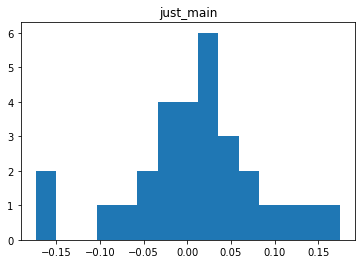

just_main
mean (std): 0.008 0.074
median: 0.013
prob > 0: 0.586




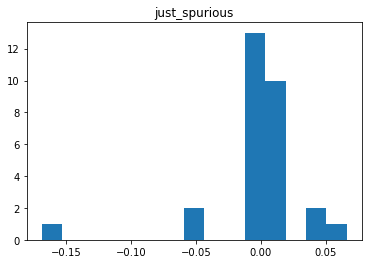

just_spurious
mean (std): -0.001 0.038
median: 0.003
prob > 0: 0.69




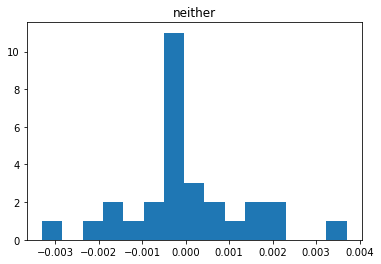

neither
mean (std): -0.0 0.001
median: -0.0
prob > 0: 0.379




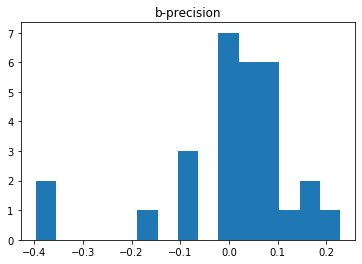

b-precision
mean (std): 0.012 0.135
median: 0.051
prob > 0: 0.724




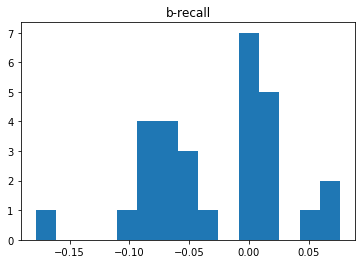

b-recall
mean (std): -0.028 0.055
median: -0.007
prob > 0: 0.31




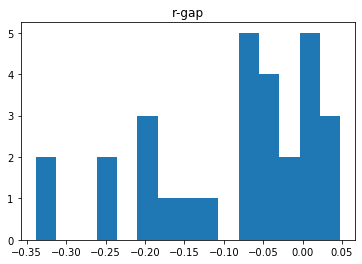

r-gap
mean (std): -0.09 0.108
median: -0.055
prob < 0: 0.759




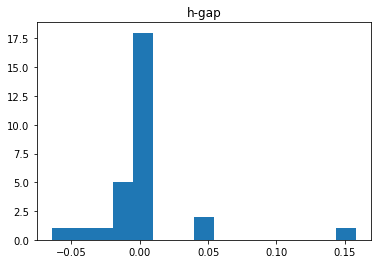

h-gap
mean (std): 0.001 0.036
median: -0.003
prob < 0: 0.759




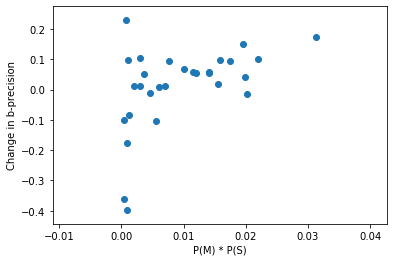

In [4]:
compare('auto-aug', 'initial-tune')



person

cell+phone-person
P(M), P(S|M), P(S): 0.041 0.797 0.542
Acc Comparison
         Mode    both just_main just_spurious neither b-precision b-recall   r-gap   h-gap
      fs-tune  0.2471    0.2273        0.9858  0.9981      0.5804   0.2372  0.0213  0.0123
 initial-tune  0.2824    0.3239        0.9845  0.9958      0.5956   0.3031  0.0415  0.0113


handbag-person
P(M), P(S|M), P(S): 0.058 0.91 0.542
Acc Comparison
         Mode    both just_main just_spurious neither b-precision b-recall   r-gap  h-gap
      fs-tune  0.2251       0.0        0.9748  0.9988      0.3611   0.1125  0.2251  0.024
 initial-tune   0.242    0.0083        0.9754  0.9995      0.3946   0.1252  0.2337  0.024


donut-person
P(M), P(S|M), P(S): 0.013 0.548 0.542
Acc Comparison
         Mode    both just_main just_spurious neither b-precision b-recall   r-gap   h-gap
      fs-tune  0.2424    0.4741        0.9984  0.9979      0.7309   0.3583  0.2317  0.0012
 initial-tune  0.2727    0.4397        0.9981  0.9976    

P(M), P(S|M), P(S): 0.06 0.478 0.1
Acc Comparison
         Mode    both just_main just_spurious neither b-precision b-recall   r-gap  h-gap
      fs-tune  0.4983    0.3242         0.892    0.99      0.3315   0.4113  0.1741  0.098
 initial-tune  0.5403     0.353        0.8707  0.9908      0.3165   0.4466  0.1872   0.12




sheep

dog-sheep
P(M), P(S|M), P(S): 0.037 0.026 0.013
Acc Comparison
         Mode    both just_main just_spurious neither b-precision b-recall   r-gap   h-gap
      fs-tune  0.3417    0.6163        0.9375  0.9855      0.3293    0.479  0.2746   0.048
 initial-tune     0.2    0.5741        0.9417  0.9924       0.424   0.3871  0.3741  0.0528


bird-sheep
P(M), P(S|M), P(S): 0.027 0.013 0.013
Acc Comparison
         Mode    both just_main just_spurious neither b-precision b-recall   r-gap   h-gap
      fs-tune  0.2097     0.358           1.0  0.9984       0.909   0.2838  0.1483  0.0016
 initial-tune  0.2258     0.422        0.9885  0.9956      0.6218   0.3239  0.1962  0

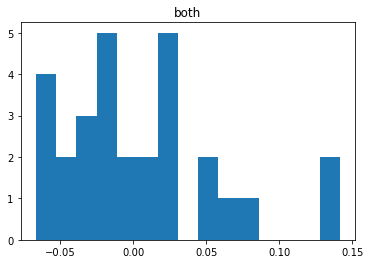

both
mean (std): 0.006 0.051
median: 0.0
prob > 0: 0.483




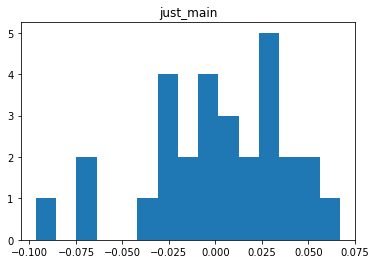

just_main
mean (std): 0.001 0.037
median: 0.005
prob > 0: 0.517




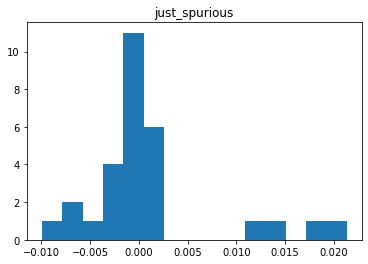

just_spurious
mean (std): 0.001 0.007
median: -0.001
prob > 0: 0.483




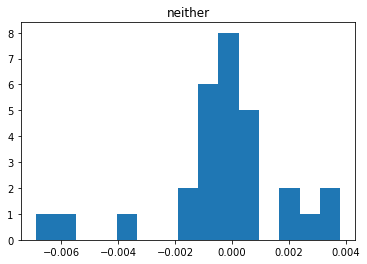

neither
mean (std): -0.0 0.002
median: 0.0
prob > 0: 0.379




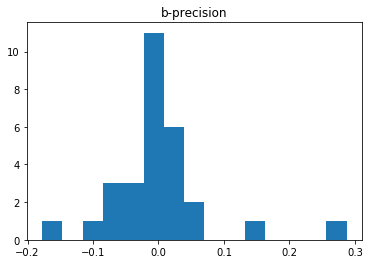

b-precision
mean (std): 0.0 0.076
median: -0.003
prob > 0: 0.414




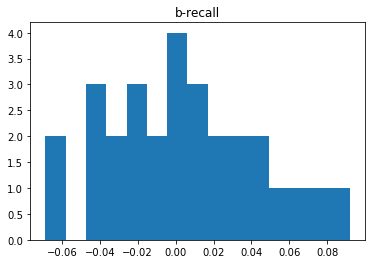

b-recall
mean (std): 0.003 0.04
median: 0.002
prob > 0: 0.517




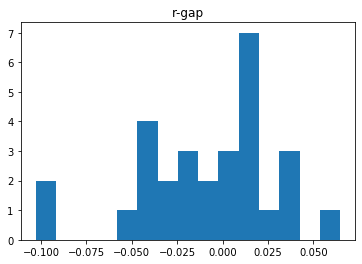

r-gap
mean (std): -0.009 0.038
median: -0.001
prob < 0: 0.517




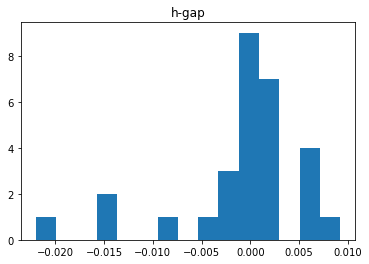

h-gap
mean (std): -0.001 0.007
median: 0.001
prob < 0: 0.345




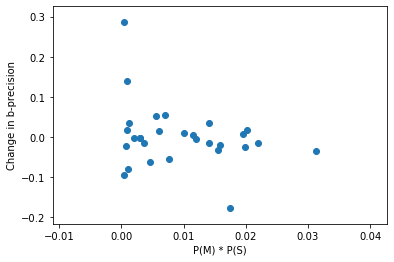

In [5]:
compare('fs-tune', 'initial-tune')